In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from math import inf

from IPython.display import display
from tqdm.auto import tqdm

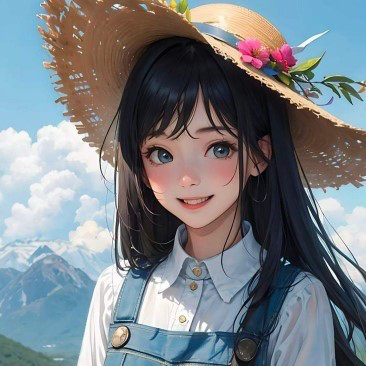

In [29]:
image = Image.open('image2.jpg')
image

In [30]:
r, g, b = image.split()

In [31]:
img = np.array([[[x/255 for x in y] for y in z] for z in np.asarray(image)])

In [32]:
channels = ["Reds", "Greens", "Blues"]
def showRGBImageChannels(image: np.array, figy=12, v=(1,0)):
    ly = len(image)
    lx = len(image[0])
    ratio = ly/lx
    figsize = (figy*ratio,figy)
    plt.figure(figsize= figsize)
    for i in range(3):
        channel_img = image[:,:,i]
        plt.subplot(1, 3, i+1)
        plt.axis("off")
        plt.imshow(channel_img.tolist(), cmap=channels[i], vmax=v[0], vmin=v[1])
    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    plt.show()

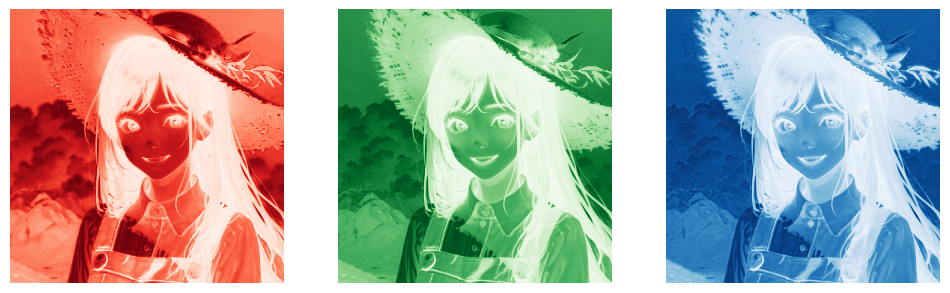

In [33]:
showRGBImageChannels(img, figy=12)

In [155]:
def showImages(images: list, figy=12, v=None, cmap='binary', titles=[]):
    ly = len(images[0])
    lx = len(images[0][0])
    ratio = ly/lx
    figsize = (figy*ratio,figy)
    plt.figure(figsize= figsize)
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.axis("off")
        if i < len(titles):
            plt.title(titles[i])
        if v:
            plt.imshow(images[i], cmap=cmap, vmax=v[0], vmin=v[1])
        else:
            plt.imshow(images[i], cmap=cmap)

    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    plt.show()

In [85]:
class ColveOutput:
    def __init__(self, kernel: np.array, channels: list[np.array], output: np.array):
        self.kernel = kernel
        if len(channels) == 3:
            self.mode = "rgb"
            self.r = channels[0]
            self.g = channels[1]
            self.b = channels[2]
        else:
            self.mode = "multi"
            self.channels = channels
        self.output = output


In [35]:
def convolve2d(metrics: np.array, kernel: np.array, strides: int, zero_padding: int):
    assert strides > 0
    assert zero_padding >= 0
    assert len(kernel) == len(kernel[0])

    extent = len(kernel)
    metrics = np.pad(metrics, (zero_padding, zero_padding))
    result = []
    for y in range(0, len(metrics) - 2*zero_padding, strides):
        row = []
        for x in range(0, len(metrics[0]) - 2*zero_padding, strides):
            dot_sum = np.sum(metrics[y: y + extent, x: x + extent] * kernel)
            row.append(dot_sum)
        result.append(row)

    return np.array(result)

In [153]:
def convolve3d(metrics3d: np.array, kernel: np.array, strides: int, zero_padding: int) -> ColveOutput:
    slices_conv = []
    for d in range(metrics3d.shape[-1]):
        slice_arr = metrics3d[:, :, d]
        slice_conv = convolve2d(slice_arr, kernel=kernel, strides=strides, zero_padding=zero_padding)
        slices_conv.append(slice_conv)

    return ColveOutput(kernel, slices_conv, np.sum(slices_conv, axis=0))


In [17]:
def relu(metrics: np.array):
    return np.array([[max(0,x) for x in y] for y in metrics])

In [68]:
def convolve3d_all(metrics3d: np.array, kernels: np.array, strides: int, zero_padding: int, apply_relu: bool = False):
    result = []
    for kernel in tqdm(kernels, total=len(kernels)):
        conv_img = convolve3d(metrics3d, kernel, strides=strides, zero_padding=zero_padding)
        if apply_relu:
            conv_img.output = relu(conv_img.output)
        result.append(conv_img)
    
    return result

In [53]:
def pooling(conv_output: ColveOutput, extent: int, stride: int):
    result = []
    for y in range(0, len(conv_output.output), stride):
        row = []
        for x in range(0, len(conv_output.output[0] - extent), stride):
              row.append(conv_output.output[y: y + extent, x: x + extent].max())
        result.append(row)
    return np.array(result)

In [69]:
def pooling_all(metricses: list[ColveOutput], extent: int, stride: int):
    result = []
    for metrics in tqdm(metricses, total=len(metricses)):
        result.append(pooling(metrics, extent=extent, stride=stride))
    return result

### Conv Relu Pooling

In [156]:
def show_conv_output(img: np.array, output: ColveOutput, show_kernel = False, show_channels = False, show_pooling = False, pooling_extent = 2, pooling_stride = 2):
    if show_kernel:
        showImages([output.kernel], figy=1, cmap=None)

    if show_channels:
        if output.mode == 'rgb':
            print("RGB convolution")
            showRGBImageChannels(np.dstack([output.r, output.g, output.b]), figy=8)
        else:
            print("Channel convolution")
            showImages(output.channels, figy=int(8*len(output.channels)/3))
    
    print("Overall convolution")

    imgs = [img, output.output]
    titles = ["Original", "Convoluation"]
    
    if show_pooling:
        imgs.append(pooling(output, extent=pooling_extent, stride=pooling_stride))
        titles.append("Pooling")


    showImages(imgs, figy=10, titles=titles)

In [146]:
kernels = [
    np.array([[0,0,0], [1,1,1], [0,0,0]]),
    np.array([[0, 1, 0], [0, 1, 0],[0, 1, 0]]),
    np.array([[1/3, 0, -1/3], [1/3,0,-1/3],[1/3,0,-1/3]]),
    np.array([[1/3,1/3,1/3], [0,0,0], [-1/3,-1/3,-1/3]]),
    np.array([[-0.11152325701837433, -0.08792960297788997, -0.0727491899130822, -0.08792960297788997, -0.11152325701837433], [-0.08792960297788997, -0.002787286223098597, 0.11291893911033585, -0.002787286223098597, -0.08792960297788997], [-0.0727491899130822, 0.11291893911033585, 1.0, 0.11291893911033585, -0.0727491899130822], [-0.08792960297788997, -0.002787286223098597, 0.11291893911033585, -0.002787286223098597, -0.08792960297788997], [-0.11152325701837433, -0.08792960297788997, -0.0727491899130822, -0.08792960297788997, -0.11152325701837433]])
]

In [147]:
conv_imgs = convolve3d_all(img, kernels=kernels, strides=1, zero_padding=2, apply_relu=True)

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


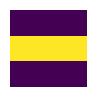

RGB convolution


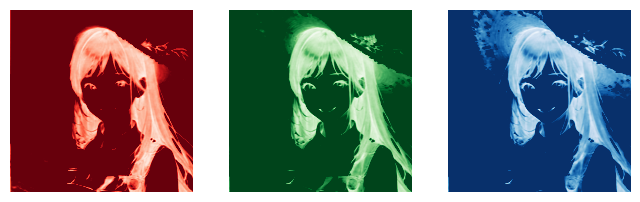

Overall convolution


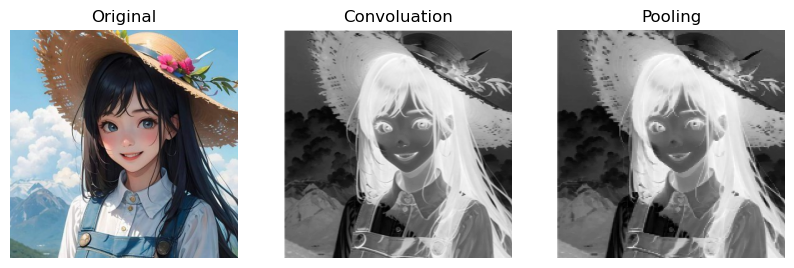

In [157]:
show_conv_output(img, conv_imgs[0], show_kernel=True, show_channels=True, show_pooling=True)

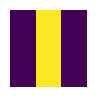

RGB convolution


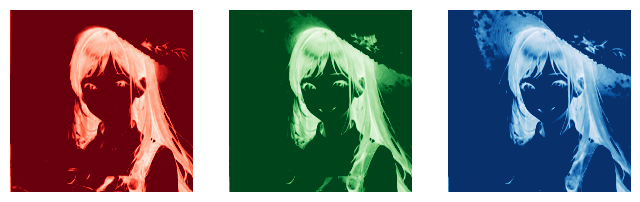

Overall convolution


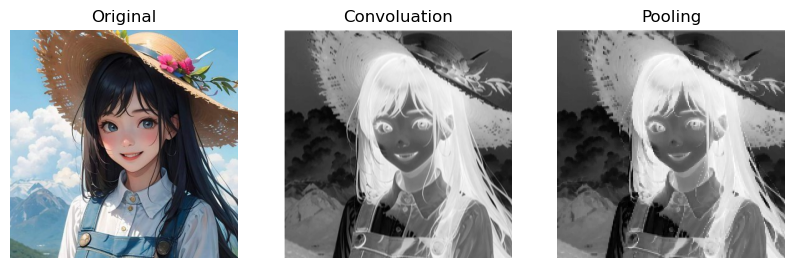

In [158]:
show_conv_output(img, conv_imgs[1], show_kernel=True, show_channels=True, show_pooling=True)

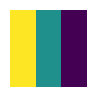

RGB convolution


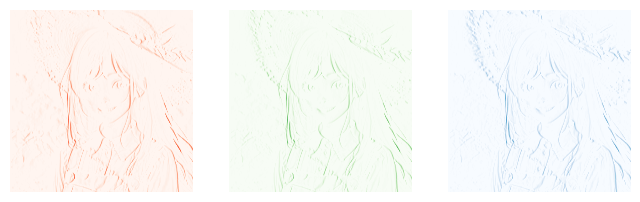

Overall convolution


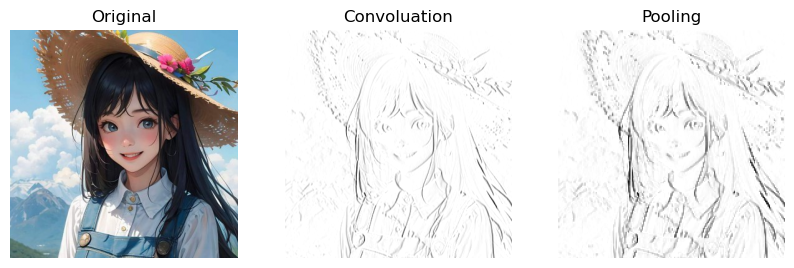

In [159]:
show_conv_output(img, conv_imgs[2], show_kernel=True, show_channels=True, show_pooling=True)

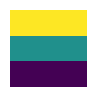

RGB convolution


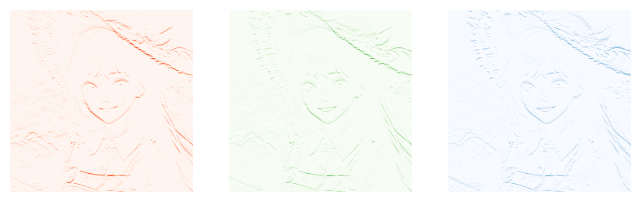

Overall convolution


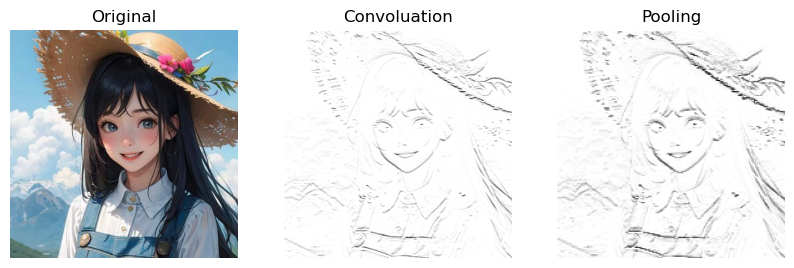

In [160]:
show_conv_output(img, conv_imgs[3], show_kernel=True, show_channels=True, show_pooling=True)

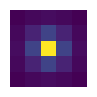

RGB convolution


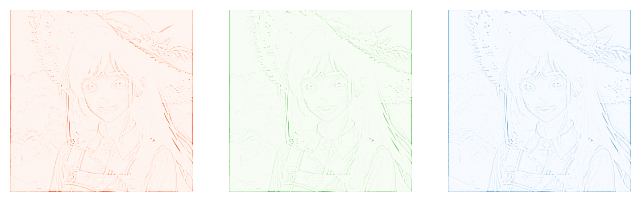

Overall convolution


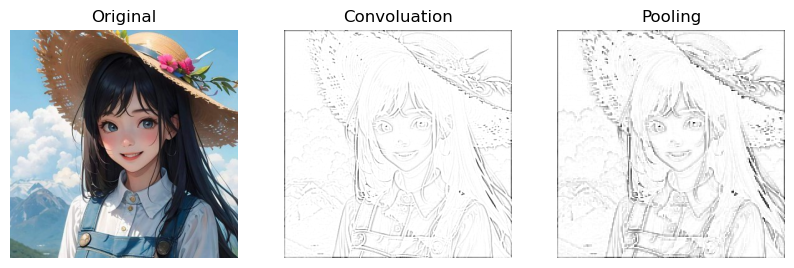

In [161]:
show_conv_output(img, conv_imgs[4], show_kernel=True, show_channels=True, show_pooling=True)